# Задание 1
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).\
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете,
так и на части (сэмпле) данных.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Считываем и смотрим как выглядят данные

In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [3]:
reg_data.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [4]:
reg_data.shape

(1000000, 2)

In [5]:
auth_data.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


In [6]:
auth_data.shape

(9601013, 2)

Провереяем данные о времени регистрации на пропуски, все ок

In [7]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

Провереяем данные о времени захода пользователей в игру, тут все тоже ок

In [8]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

**Переводим UNIX-время в более привычный глазу формат**

In [9]:
reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s').dt.date
auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s').dt.date

**Джойним к таблице с авторизацией (auth_data) данные с датой регистрации (reg_data) по uid**

In [10]:
df_merged = auth_data.merge(reg_data, how='left', on='uid')\
                     .rename(columns={'reg_ts':'reg_day'})\
                     .set_index('reg_day')

Смотрим что получилось, выглядит ок

In [11]:
df_merged.head(3)

,auth_ts,uid
reg_day,,
1998-11-18,1998-11-18,1
1999-07-22,1999-07-22,2
1999-07-22,1999-07-25,2


In [15]:
df_merged.dtypes

auth_ts    object
uid         int64
dtype: object

**Смотрим описательные статистики, чтобы понять за какой период данные.**\
Смотрим только по auth_ts, поскольку, если я правильно понимаю, первая авторизация для каждого игрока = дате регистрации.\
Тут пришлось открыть дату через datetime, т.к метод describe не выводил данные о min вместе со всей остальной статистикой.\
Да, можно было отдельно посмотреть, но я захотел, чтобы все показывалось через одну строку кода)

In [16]:
pd.to_datetime(auth_data.auth_ts).describe(datetime_is_numeric=True)

count                          9601013
mean     2019-01-29 04:12:09.041572096
min                1998-11-18 00:00:00
25%                2018-06-07 00:00:00
50%                2019-07-31 00:00:00
75%                2020-04-02 00:00:00
max                2020-09-23 00:00:00
Name: auth_ts, dtype: object

**Приступаем к самому главному - созданию функции по построению когорнтного анализа retention по дням со следующими параметрами:**

* **df_merged** - предварительно сджойненная таблица (авторизация + первая регистрация)
* **start_date** и **end_date** - это параметры для выборка интересующего нас периода регистрации игроков
* **cohort** - указываем период/размер кагорты - ('d') день, ('w') неделя или ('m') месяц 
* **days** - число дней после регистрации, которые нас интересуют (цифру нужно указать без скобок). Если нас интересуют все возможные дни, то надо указать "None".

In [17]:
def daily_retention_by_cohort(df_merged, start_date, end_date, cohort, days):

        # Переводим даты начала и конца периода в работающий формат
    start_date_f = pd.to_datetime(start_date)
    end_date_f   = pd.to_datetime(end_date)

        # Поскольку в сджойненной таблице индексом мы поставили дату регистрации, то фильтурем период с помощью .loc
    ret_sample = df_merged.sort_values('reg_day', ascending=True)\
                          .loc[start_date_f:end_date_f]\
                          .reset_index(drop=False)

        # Определяем кол-во дней прошедших после регистрации для каждой авторизации и переводим в работающий формат
    ret_sample['Days_after_reg'] = ret_sample['auth_ts'] - ret_sample['reg_day']
    ret_sample['Days_after_reg'] = ret_sample.Days_after_reg.dt.days

        # Фильтруем часть данных, если в параметрах указали что нас интресуют не все возможные дни, а, например, только 30 дней
    if days != 'None':
        ret_sample = ret_sample.query('Days_after_reg <= @days')

        # Меняем формат данных о регистрации, чтобы дальше все работало
    ret_sample['reg_day'] = pd.to_datetime(ret_sample.reg_day)

        # Следующие три if определяю к какой кагорте будет относится авторизация в зависимости от заданных нами параметров.
        # С днями все очевидно.
    if cohort == "d":
        ret_sample['Cohort'] = ret_sample['reg_day'] 

        # Определяем дату начала недели.
        # Тут стоит отметить, что здесь указывается именно понедельник, чтобы все дни в когортном анализе были сопоставимы,
        # т.е чтобы 0-й день во всех корогтах был понедельником, 1-й день - вторником и т.д.
        # Сделано это специально, чтобы визуальное сравнение когорт между собой было болле простым.
        # Момент, наверное, спорный и будть это реальное задание обязательно уточнил бы его у менеджера. 
    if cohort == "w":
        ret_sample['Cohort'] = ret_sample['reg_day'] - ret_sample['reg_day'].dt.weekday.astype('timedelta64[D]') 

        # Определяем дату начала месяца
    if cohort == "m":
        ret_sample['Cohort'] = ret_sample['reg_day'].dt.floor('d') - pd.offsets.MonthBegin(1)

        # Группируем данные и приводим в привичный для когортного анализа вид
        # (слева - периоды когорт, сверху - дни после регистрации)
    df_cohort = ret_sample.groupby(['Cohort', 'Days_after_reg'])\
                          .agg(n_users=('uid', 'nunique'))\
                          .reset_index(drop=False)
    
        # Заранее форматируем дату, чтобы при стилизации она отображалась без секунд, минут, часов и т.д.
    df_cohort['Cohort'] = df_cohort.Cohort.dt.strftime("%m/%d/%Y")

    cohort_pivot = df_cohort.pivot_table(index = 'Cohort',
                                         columns = 'Days_after_reg',
                                         values = 'n_users')

    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    
    # Все что идет ниже - стилизация для простоты восприятия
    
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # Стилизация для самой retention matrix, которую получили итогом после применения функции
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='BuGn', 
                ax=ax[1])
    ax[1].set_title('Players retention by cohorts', fontsize=18)
    ax[1].set(xlabel='Days',
              ylabel='')

    # Колонка с числом игроков в каждой когорте
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Сohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

# Проверка функции:)
Работает долго, так как на вход получает полные данные

Напоминание по входящм данным:
* **df_merged** - предварительно сджойненная таблица (авторизация + первая регистрация)
* **start_date** и **end_date** - это параметры для интересующего нас периода регистрации игроков
* **cohort** - указываем период/размер кагорты - ('d') день, ('w') неделя или ('m') месяц 
* **days** - число дней после регистрации, которые нас интересуют (цифру нужно указать без скобок). Если нас интересуют все возможные дни, то надо указать "None".

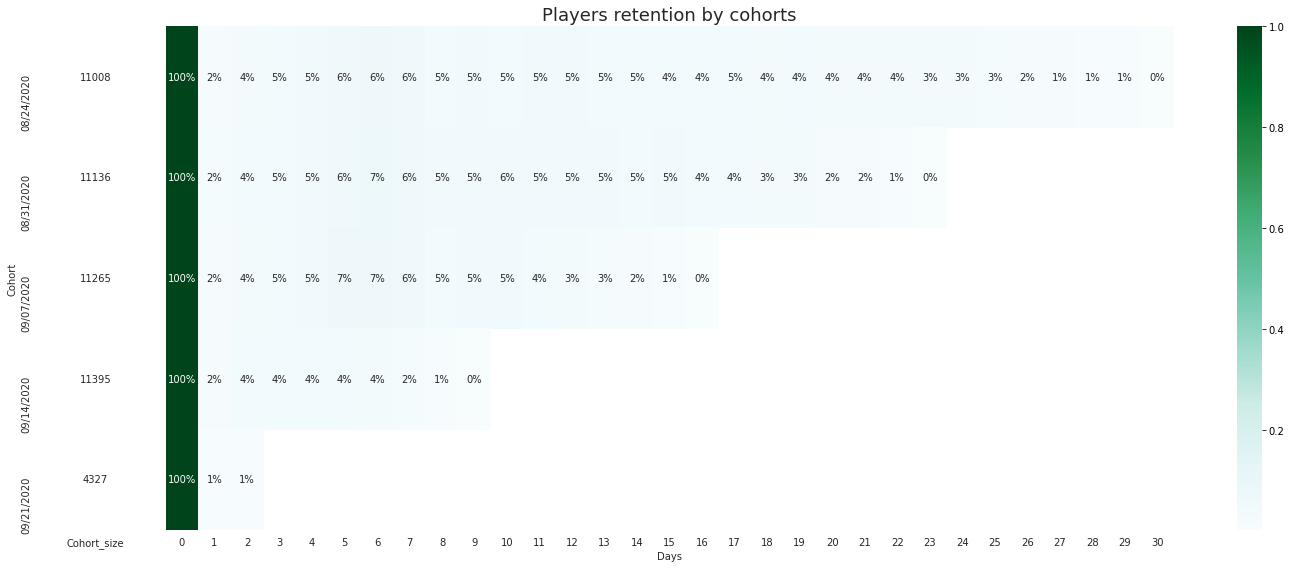

In [18]:
daily_retention_by_cohort(df_merged, start_date='2020-08-24', end_date='2020-09-23', cohort="w", days=30)